# Stay In Your Lane!
## Automated Bike Lane Enforcement With Neural Network Image Classification: Technical Notebook
### Author: Jesse Markowitz, October 2021

<img src="readme_images/cab_in_bikelane.png" alt="a scene often seen in NYC" width="600"/>

In [37]:
# Load dependencies
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import models
from keras.layers import Dense, Flatten
from pickle import load

from functions import *

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Delete metadata files created by Mac OS
!find . -name ".DS_Store" -delete

## Business Understanding

Biking is my primary mode of transportation in and around New York City, as it is for an increasing number of people every year. I bike to commute to work, for groceries or other personal trips, and for exercise/pleasure. However, on every single trip I make in the city, I face a serious safety issue: **cars parked in bike lanes force me to weave in and out of traffic.** Although it is illegal to stop, stand, or park in a bike lane, vehicles in the city frequently do. Despite an increase in bike infrastructure and ridership in NYC, this problem continues, seemingly unenforced and unabated. The worst offenders are Taxi and Limousine Commission (T&LC) cars (yellow and green cabs, as well as rideshare vehicles for Uber, Lyft, etc.), delivery trucks, and police vehicles (personal and service). While it is possible to report offenders via 311 (the [Reported app](https://reportedly.weebly.com/) makes this especially easy), in general it is only T&LC drivers who are held accountable for these violations, as there is a set of prosecutors specifically for that regulatory purpose. When it comes to personal and police vehicles, 311 forwards the complaint to the local police precinct, where it is up to the responding officer's discretion to follow up. This rarely occurs. **Insufficient enforcement of bike lane traffic laws creates serious safety issues for cyclists.**

<img src="readme_images/blocked_bike_lane_nj_port_authority.png" alt="yet another cop in the bike lane" width="600"/>

On September 15, 2021, the NYC DOT released a ["Request for Expressions of Interest"](https://a856-cityrecord.nyc.gov/RequestDetail/20210907107) to create a system for automated bike lane enforcement. A system for bus lanes called the Automated Bus Lane Enforcement (ABLE) system was created by [Siemens Mobility](https://www.mobility.siemens.com/us/en/company/newsroom/short-news/first-ever-mobile-bus-lane-enforcement-solution-in-new-york.html) and installed in 2010 and has been expanded since then with great success, as measured by increased route speed and ridership. Automating enforcement of bike lane traffic laws would have the immediate effect of increase enforcement from what seem to be negligible levels. Automated enforcement would also benefit the city's cyclists by reducing the need for active police involvement with the issue, especially on streets where the problem is the greatest.

The scope of this project is limited to train a model to recognize when a vehicle is obstructing a bike lane, given that the images used for training are guaranteed to contain a bike lane. This scope is based on the idea of an automated enforcement system comprised of stationary cameras placed on streets with bike lanes. The cameras would point up or down the street in order to monitor as much of the length of the bike lane as possible.

Models are evaluated using accuracy and precision (the true-positive rate), as well as an inspection of model decision-making using the [Lime](https://github.com/marcotcr/lime) package. Precision is used to ensure that false-positives are kept to a minimum. 

## Data Understanding and Preparation

The dataset consists of just over 1,800 images of New York City bike lanes, up from about 1,600 at the beginning of the project. Just over half of these images are of a bike lane obstructed by a vehicle, which comprises the target class. The rest of the images are of bike lanes without vehicular obstruction, showing entirely empty bike lanes or, on occassion, bike lanes with cyclists or pedestrians. The small size of the dataset is one of the most significant limitations of this project.

The images in the dataset were collected from a variety of sources:
 - The [Reported app's Twitter page](https://twitter.com/Reported_NYC), which tweets all traffic violations reported through the app
 - A large dataset of images provided by [Ryan Gravener](https://github.com/snooplsm), who is working on an image recognition project for Reported
 - Screenshots from Google Maps Street View
 - Manual collection (i.e., taking photos while biking around the city--this is the source of the vast majority of the non-target images of unobstructed bike lanes)

### Preprocessing

#### Re-orienting images
All of the images collected manually were taken with an iPhone X and saved as jpegs. Because we want to display images oriented correctly, digital cameras and smartphone cameras attach an Orientation tag to the EXIF data with each photo taken. This allows the photograph to orient the camera as they need to and ensures that the photo will be displayed correctly:

![image orientation tags](readme_images/orient_flag2.png)
[(source)](https://jdhao.github.io/2019/07/31/image_rotation_exif_info/)

This tag is read by most image display programs in order to orient the image correctly without altering the underlying image data, but a Keras `ImageDataGenerator` does not do this. As a result, images collected manually may be improperly oriented when fed into the model and may be turned by 90° or 180°:

![unoriented images](readme_images/unoriented_images.png)

To solve this issue, the `exif_transpose` method from `PIL.ImageOps` was used in a custom `reorient_images` function to create a correctly oriented copy of every image in the dataset. This results in a dataset of correctly oriented images, as demonstrated below:

In [4]:
# Read files in as images
# Directories
train_dir = 'input_images/full_combined'
train_open_dir = os.path.join(train_dir, 'open_bike_lane')
train_vehicle_dir = os.path.join(train_dir, 'vehicle_bike_lane')

oriented_open_images = get_images(train_open_dir, num_images=5)

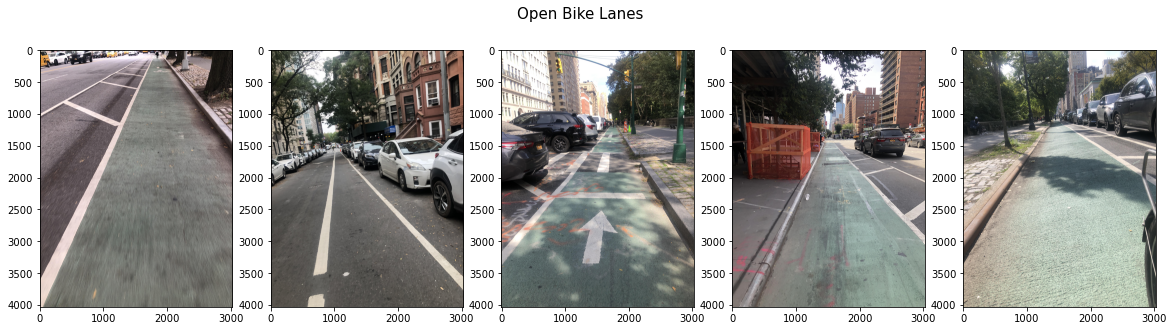

In [6]:
fig, axs = plt.subplots(1, 5, figsize=(20, 5))

for i, ax in enumerate(axs):
    ax.imshow(oriented_open_images[i])
fig.suptitle('Open Bike Lanes', fontsize=15)
fig.tight_layout;

The `reorient_images` function was applied to all images in the dataset in order to save a new, reoriented copy of every image. The original images were then discarded. More details and code about this issue can be found in the [EDA notebook](code/EDA); the `reorient_images` function is found in [`functions.py`](code/functions.py).

#### Cropping images
Many of the images collected via Reported contain timestamps printed at the top of the image: 

In [7]:
# Read files in as images
uncropped_dir = 'other_images/imgs_to_crop'
uncropped_vehicle_dir = os.path.join(uncropped_dir, 'vehicle')

uncropped_vehicle_images = get_images(uncropped_vehicle_dir, num_images=5)

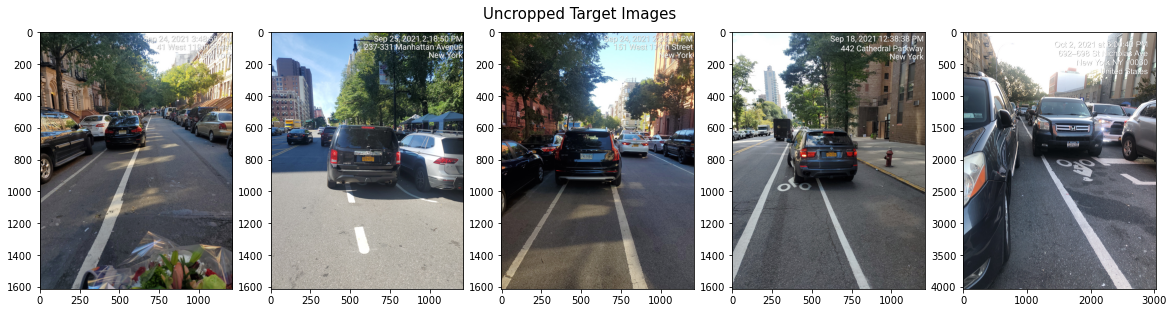

In [8]:
# Display uncropped images
fig, axs = plt.subplots(1, 5, figsize=(20, 5))

for i, ax in enumerate(axs):
    ax.imshow(uncropped_vehicle_images[i])
fig.suptitle('Uncropped Target Images', fontsize=15, y=0.93)
fig.tight_layout;

The timestamp enhances the photo's value as evidence in a potential case, but creates a potentially confounding factor in the dataset because images with timestamps will be overrepresented in the target class. Without removing this feature, it's possible that the model will use it to predict the target class, rather than attending to real features in the image.

Cropping the top 175 pixels of the image is an easy way to remove the entire timestamp for most images, while preserving the important features of the image:

In [9]:
# List of filenames
vehicle_filenames = os.listdir(uncropped_vehicle_dir)

# Crop the images
cropped_vehicle_images = [crop_image(uncropped_vehicle_dir, name) for name in vehicle_filenames]

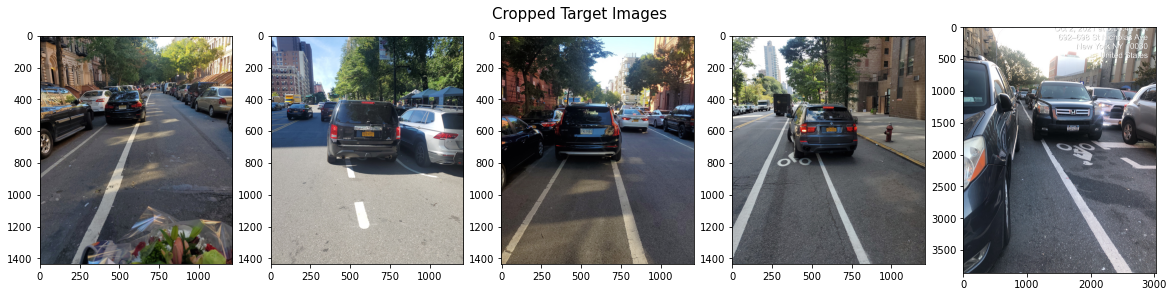

In [10]:
# Display results
fig, axs = plt.subplots(1, 5, figsize=(20, 5))

for i, ax in enumerate(axs):
    ax.imshow(cropped_vehicle_images[i])
fig.suptitle('Cropped Target Images', fontsize=15, y=0.9)
fig.tight_layout;

Notice how the final image still contains some timestamp. Although cropping out the top 175 rows of pixels from an image was sufficient for most images, it is still necessary to visually inspect the results and manually crop more if necessary. More details and code can be found in the [crop_timestamp](code/crop_timestamp) notebook.

#### Removing unclear images
The final step before a train-val-test split is to manually review images, ensuring they are in the correct class directory, and removing any that are inappropriate or unclean. Images were generally removed that:
 - did not show both lane lines of a bike lane (lines too faint or photo taken too "close up" to a vehicle)
 - showed a bike lane from the side (photo was taken from across the street, facing across the street or toward the sidewalk)
 - contained too many cyclists, motorbikes, or pedestrians such that the bike lane was significantly obstructed
 - were taken at night (these were extremely overrepresented in the target class)
 - showed a car crossing a bike lane legally (i.e., crossing an intersection) or parked in a legally ambiguous zone
 - were ambiguous (such as showing a potential vehicular obstruction too far in the distance to tell for sure)

The following are a small set of representative examples of the over 200 images that were ultimately removed from the orginal dataset:

![examples of unused images](readme_images/examples_unused.png)

Some images that were unclear were cropped in order to keep them in the dataset. For instance, an image like the one to the far right could be cropped in order to show the open bike lane, removing the possible vehicular obstruction entirely and placing the image in the non-target class folder. This manual operation was performed on several images in order to avoid removing data from the already small dataset.

Many of these decisions were subjective judgments and there were a surprisingly large number of images that were ambiguous. These images were kept in a separate `unused_images` folder for later inclusion or testing and as non-examples. 

Because the dataset is also limited, it was thought best to restrict the data to only the clearest examples that match the intended use with an automated enforcement system and scope of the project. The hope is that with more data and continued model training, a model can be created that also recognizes pedestrians or cyclists as well.

### Train-Validation-Test Split

Only 100 images (50 of each class) were set aside as a testing/holdout set for final model evaluation in order to maximize the training set. An additional 100 images (50 of each class) have been set aside as a `validation` set to use during model training. The [split-folders](https://pypi.org/project/split-folders/) package provides an easy way to accomplish this and has methods for splitting either by a ratio or a fixed number. 

My first split was as follows:
```python
# Split off test set
splitfolders.fixed("other_images/processed_images", 
                   output="input_images", 
                   seed=42, 
                   fixed=(50))
```
I continued to collect more images throughout the beginning of the project to increase the size of the dataset. As new images were collected, they were added to a separate `new` folder, separate from the original `train` image set, then combined in a separate `full_combined` folder to be used for continued model training. 

I actually split twice because I did not start with a `validation` set, opting instead to use the `validation_split` parameter in Keras's `ImageDataGenerator` class. However, this causes two serious data issues. 

First, it creates a non-random validation set because `validation_split=0.1` simply withholds the last 10% of images in the dataset. Since my images are arranged alphabetically and their names are determined by their source, that meant that some sets of images, such as Google Maps Street View screenshots, were being used exclusively for either training or validation. A non-random validation sample is not ideal.

The second issue with `validation_split` is that it still applies image augmentation to the validation set, meaning that the model is being validated on unrealistic data. (See below for more dicussion and examples of image augmentation.)

To solve both of these issues in one, I re-split my training data to create a separate `validation` folder to use with a separate `ImageDataGenerator` rather than by using `validation_split`:
```python
# Split off validation set
splitfolders.fixed("input_images/full_combined", 
                   output="input_images/validation", 
                   seed=42, 
                   fixed=(50))
```

This resulted in the following file structure for processed images:

```
└── input_images
    ├── full_combined
    ├── new
    ├── test
    ├── train
    └── validation
```
Each folder of images contains 2 subfolders to designate image classes, as shown below with one example:
```
└── input_images
    ├── full_combined
    │    ├──open_bike_lane
    │    └──vehicle_bike_lane
```

### Class distribution

I ensured that both the `validation` and holdout `test` sets contained an even 50/50 split of image classes. Overall, there is a fairly balanced distribution of the classes in the full training image dataset.

In [11]:
# Check functionality and number of images
print('There are', len(os.listdir(train_open_dir)), 'non-target images in the training set')
print('There are', len(os.listdir(train_vehicle_dir)), 'target images in the training set')

# Expecting:
# 758 non-target
# 861 target

There are 758 non-target images in the training set
There are 861 target images in the training set


<ipython-input-12-aa3cbb8e6ffa>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([str(int(p*100))+'%' for p in ax.get_yticks()])


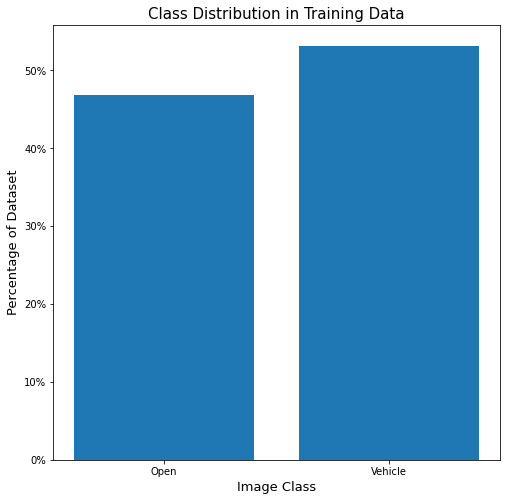

In [12]:
# Visualize class distribution in training data
num_open = len(os.listdir(train_open_dir))
num_vehicle = len(os.listdir(train_vehicle_dir))
total_images = num_open + num_vehicle
fig, ax = plt.subplots(figsize=(8, 8))

ax.bar(x=['Open', 'Vehicle'], height=[num_open/total_images, 
                                                  num_vehicle/total_images])
ax.set_title('Class Distribution in Training Data', size=15)
ax.set_ylabel('Percentage of Dataset', size=13)
ax.set_xlabel('Image Class', size=13)
ax.set_yticklabels([str(int(p*100))+'%' for p in ax.get_yticks()])
plt.show()

Although there are slightly more target class images, this imbalance was not considered large enough to be a serious issue.

### Image Samples

Below are samples of a few images from each class.

In [19]:
# Load images
open_images = get_images(train_open_dir, num_images=10)
vehicle_images = get_images(train_vehicle_dir, num_images=5)

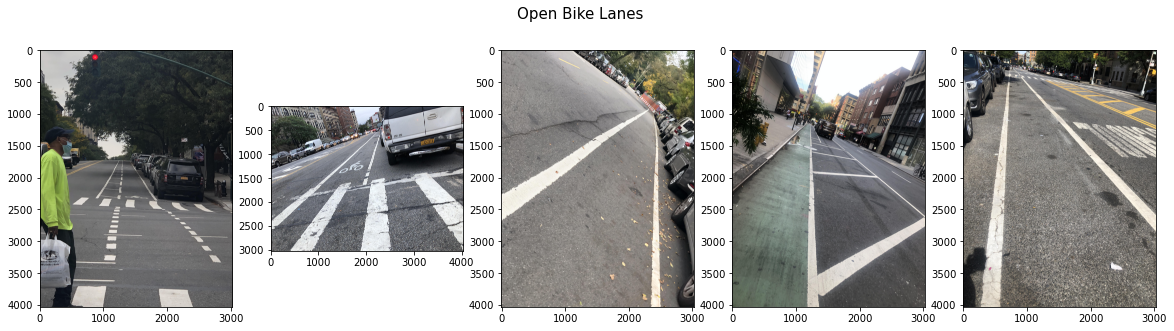

In [22]:
# Images of open bike lanes
fig, axs = plt.subplots(1, 5, figsize=(20, 5))

for i, ax in enumerate(axs):
    ax.imshow(open_images[i+5]) # See some new ones
fig.suptitle('Open Bike Lanes', fontsize=15)
fig.tight_layout;

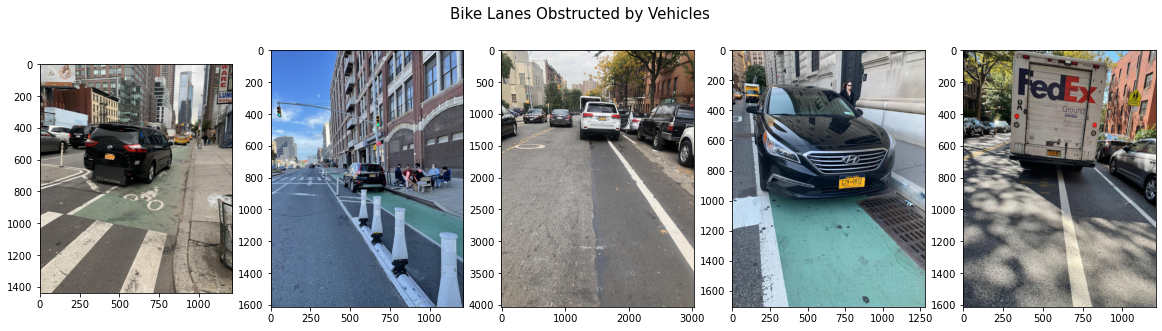

In [23]:
# Images of bike lanes obstructued by vehicles
fig, axs = plt.subplots(1, 5, figsize=(20, 5))

for i, ax in enumerate(axs):
    ax.imshow(vehicle_images[i])
fig.suptitle('Bike Lanes Obstructed by Vehicles', fontsize=15)
fig.tight_layout;

The hope is that a neural network, and especially the pattern-detecting filters in a convolutional neural network, will be able to detect the lane lines and vehicle shapes in the images. The images are so consistent in content and perspective and similar both within and between the classes except for the main feature (a vehicle in the bike lane). Because of this, it seems reasonable that a model can predict the classes with high accuracy, even with a small dataset

With the data processed and arranged in an appropriate file structure, it's time to get modeling!

## Modeling with Neural Networks

The following models represent key benchmarks in a process of model iteration that resulted in over 20 models trained on the data. The full set of evaluation metrics from and notes on each model can be found in the [model_tracker](models/model_tracker.csv) spreadsheet.

### First Simple Model

The first simple model consists of a basic neural network with only 1 fully connected dense layer, plus an output layer. It was originally trained on the initial smaller dataset, before more images were added, without image augmentation or any non-default parameters aside from rescaling. (The full code and training data for the First Simple Model can be found in the [FSM](code/FSM.ipynb) notebook.)

In [25]:
# Load model
fsm = models.load_model('models/fsm.h5')
# Load pickled training history
fsm_history = load(open('models/fsm_history.pkl', 'rb'))

fsm.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 196608)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                6291488   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 6,291,521
Trainable params: 6,291,521
Non-trainable params: 0
_________________________________________________________________


In [26]:
# Image folder for training
train_dir = 'input_images/train'

# Get data from directories and scale
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_gen = datagen.flow_from_directory(train_dir, subset='training', class_mode='binary')
val_gen = datagen.flow_from_directory(train_dir, subset='validation', class_mode='binary', shuffle=False)

Found 1089 images belonging to 2 classes.
Found 272 images belonging to 2 classes.


Training eval:
35/35 [==============================] - 117s 3s/step - loss: 0.4567 - acc: 0.7576 - recall: 0.7723 - precision: 0.7531

Validation eval:
9/9 [==============================] - 22s 2s/step - loss: 0.7816 - acc: 0.7096 - recall: 0.8905 - precision: 0.6559


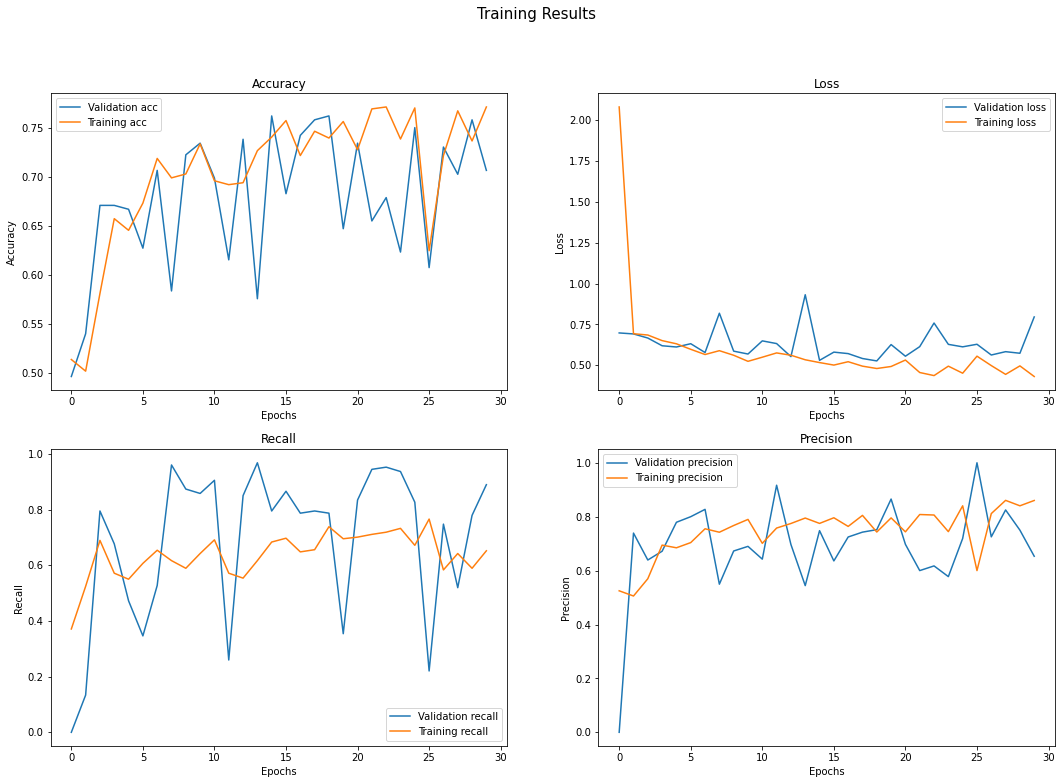

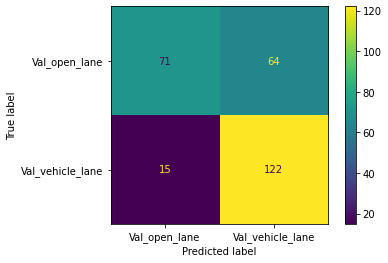

In [38]:
visualize_results(fsm_history, fsm, train_gen, val_gen)

To have metrics above 70% from the FSM was very heartening, especially with such a simple architecture. 

### Dense NN Iterations

The obvious next step to improve the model is to add more layers. The following model shows a deeper, more complex structure. It was trained on the same dataset as the FSM, with a 20% validation split. (The full code and training data for the fully connected dense NN models can be found in the [dense_NN](code/dense_NN.ipynb) notebook.)

In [40]:
# Load model
nn_model = models.load_model('models/nn_model_1.h5')
# Load pickled training history
nn_history = load(open('models/nn_model_1_history.pkl', 'rb'))

nn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 196608)            0         
_________________________________________________________________
dense (Dense)                (None, 512)               100663808 
_________________________________________________________________
dense_1 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 12)                396       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 13        
Total params: 100,699,129
Trainable params: 100,699,129
Non-trainable params: 0
__________________________________________

Training eval:
35/35 [==============================] - 167s 5s/step - loss: 0.4418 - acc: 0.7787 - recall_1: 0.6339 - precision_1: 0.8969

Validation eval:
9/9 [==============================] - 27s 3s/step - loss: 0.5293 - acc: 0.7316 - recall_1: 0.7153 - precision_1: 0.7424


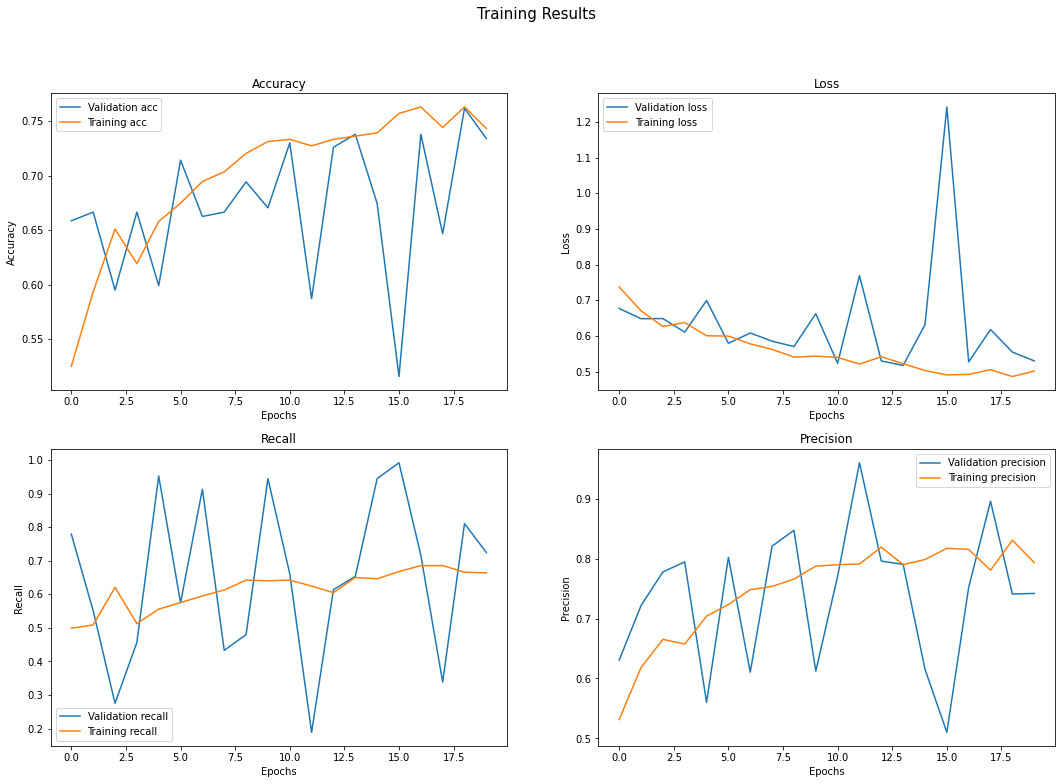

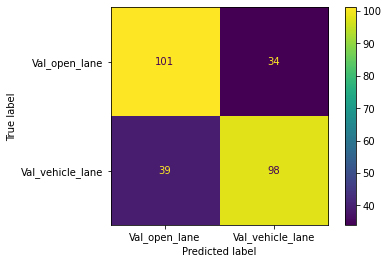

In [41]:
visualize_results(nn_history, nn_model, train_gen, val_gen)

Clearly adding more layers is beneficial for balancing out the accuracy in terms of recall and precision, but ultimately the metrics are still not great.

Given the propensity for NN models to overfit, not to mention the small dataset size, overfitting was a constant concern. Adding image augmentation to address both of these concerns only resulted in lower metrics with less consistency. Further improvements could likely be made through the addition of more complex layers, especially convolutional layers.

### Convolutional Neural Networks

By adding convolutional layers, the hope is that the model will be able to identify specific patterns in the training images. Ideally, it will be able to recognize the bike lane and lane lines themselves, as well as the front or back end of a vehicle. My initial model was incredibly adept at fitting itself to the training set--so much so that its training accuracy, recall, and precision were all at 100%, clearly overfitting the data. 

The main step taken to account for this issue, as well as to solve the issues around having a small dataset, is to introduce *image augmentation*. This technique involves altering the images that are fed into the model, often by mirroring or rotating them, zooming in or out, stretching them, or altering the brightness. The images below show the results of augmentation using the following parameters:
```python
ImageDataGenerator(rotation_range=30, 
                   horizontal_flip=True,
                   width_shift_range=.1, 
                   height_shift_range=.1,
                   brightness_range=[0.5, 1.5], 
                   zoom_range=.2)
```
![augmented images](readme_images/image_augmentation.png)

Image augmentation through the Keras `ImageDataGenerator` is performed randomly and on the fly. This allows the model to train on a variety of images beyond just those in the dataset. It's important to use parameters that the model is likely to see. I chose these parameters to account for images from either side of the street, in a variety of lighting conditions, spotting a variety of vehicles in the bike lane at a variety of distances from the camera and locations in the frame.

Several different models were evaluated with slightly different architectures, including adding BatchNormalization layers, using l2 regularization in the convlutional layers, and adding a Dropout layer to the final fully connected dense layers. The l2 regularization and Dropout layers were both successful at improving validations scores while reducing overfitting. The following model shows the structure of a model with l2 regularization.

(The full code and training data for iterations on CNN models can be found in the [CNN1](code/CNN1.ipynb) and [CNN2](code/CNN2.ipynb) notebooks.)

In [ ]:
# Load model
cnn = models.load_model('models/fsm.h5')
# Load pickled training history
fsm_history = load(open('models/fsm_history.pkl', 'rb'))

fsm.summary()